In [0]:
!pip install -q albumentations

In [5]:
import torch
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from numpy.random import randint
from typing import Dict, List
import cv2
import glob
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def dataset_to_dict(data_images,data_labels) -> Dict[int,List[np.ndarray]]:
    '''
    Turns dataset into dictionary

    # Returns
        Dictionary where the labels are the keys and data stored on each entry as a list og numpy.ndarray
    '''
    numbers = {}
    for img, label in zip(data_images, data_labels):
        if label not in numbers.keys():
            numbers[label] = []
        numbers[label] += [img]

    return numbers

def build_dataset(numbers:dict, to_tensor=True, amount:int=500):
    '''
    turns Mnist dataset into new dataset of numbers [0-100]
    '''
    data = None
    targets = np.array([])
    print('Building: 0',end='')
    for hundreds,tens,unit in np.ndindex(2,10,10):
        target = 100*hundreds + 10*tens + unit
        if(target > 100):      
            break
        nset = np.array([])
        while len(nset) < amount:
            r_unit, r_tens, r_hundreds = randint(0, len(numbers[unit])), randint(0,len(numbers[tens])), randint(0,len(numbers[hundreds]))
            permutation = np.concatenate([numbers[hundreds][r_hundreds],numbers[tens][r_tens],numbers[unit][r_unit]], axis=1)
            if nset.size == 0:    
                nset = permutation.reshape([1,28,84])
            else:
                nset = np.append(nset, [permutation], axis=0)
                
            if len(nset) % amount == 0:
                nset = np.unique(nset,axis=0) # to ensure there are no redundent permutation of an image    
        if data is None:
            data = nset
        else:
            data = np.append(data, nset, axis=0)
        targets = np.append(targets, np.ones(amount)*target, axis=0).astype(int)
        print('.', end='')
    print("100\nDone!")
    
    if to_tensor:
        return  torch.from_numpy(data), torch.from_numpy(targets)
    return data,targets


In [0]:

def augmentations(p=1,blur_limit=3):
    return Compose([
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=blur_limit, p=0.1),
            Blur(blur_limit=blur_limit, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=(-15,15),border_mode=cv2.BORDER_REPLICATE, p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            IAASharpen(),
            IAAEmboss(),         
        ], p=0.3),
    ], p=p)


class MNISTDataset(Dataset):

    def __init__(self, X_train, y_train, num_classes, transforms=None, preprocessing=None):
        super(MNISTDataset,self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self,idx):
        x = self.X_train[idx]
        y = self.y_train[idx]
        if self.transforms != None:
            x = self.transforms(image=x.numpy())
            x = x['image']/255.0
        label = np.zeros(len(self.classes))
        label[y] = 1.0
        return x, label

    def __len__(self):
        return len(self.X_train)
    

In [0]:
train_set = torchvision.datasets.MNIST(root='',download=True)
data_images = train_set.data.numpy()
data_labels = train_set.targets.numpy()
numbers = dataset_to_dict(data_images,data_labels)
X, y = build_dataset(numbers,amount=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
len(X_train),len(X_test),len(X_val)

In [9]:
batch_size = 500
aug = augmentations()
classes = [x for x in range(101)] 
train = MNISTDataset(X_train, y_train,classes,transforms=aug)
validation = MNISTDataset(X_val, y_val,classes)

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=4)
val_loader = DataLoader(validation,batch_size=1,shuffle=True,num_workers=4)

num_classes = len(train.classes)
print(f"number of classes:{num_classes}")

number of classes:101


In [0]:
class LeNetModel(nn.Module):
    param_conv1 = {'in_channels': 1,
            'out_channels': 6,
            'kernel_size':(5,5)}
    max_pooling_kize1 = 2

    param_conv2 = {'in_channels': 6,
            'out_channels': 16,
            'kernel_size':(5,5)}

    max_pooling_kize2 = 2

    param_fc1 = { 'in_features' :16*18*4, 'out_features':120}
    param_fc2 = { 'in_features' : 120, 'out_features': 84}
    param_fc3 = { 'in_features' : 84, 'out_features': num_classes}

    
    def __init__(self):
         super(LeNetModel, self).__init__()
         self.conv1 = nn.Conv2d(**self.param_conv1)
         self.conv2 = nn.Conv2d(**self.param_conv2)

         self.fc1 = nn.Linear(**self.param_fc1)
         self.fc2 = nn.Linear(**self.param_fc2)
         self.fc3 = nn.Linear(**self.param_fc3)

    def forward(self,x):
        x = self.conv1(x.float())
        x = F.relu(x)
        x = F.max_pool2d(x,self.max_pooling_kize1)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,self.max_pooling_kize2)

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)
        
        return F.softmax(x, dim=1).double()

class FocalLoss(nn.Module):
    def __init__(self, reduction='mean', alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        CE_loss = F.binary_cross_entropy(inputs,
                                         targets,
                                         reduction=self.reduction)
        prob_t = self.get_prob(CE_loss)
        return self.alpha * (1-prob_t)**(self.gamma) * CE_loss

    def get_prob(self,CE_loss):
        # extract pt from -log(pt) == CE
        return torch.exp(-CE_loss)

class FocalLossWithLogits(FocalLoss):

    def __init__(self,pos_weight=None, reduction='mean', alpha=1, gamma=2):
        super(FocalLossWithLogits, self).__init__(reduction, alpha, gamma)
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        CE_loss = F.binary_cross_entropy_with_logits(inputs,
                                                     targets,
                                                     reduction=self.reduction,
                                                     pos_weight=self.pos_weight)
        prob_t = super().get_prob(CE_loss)
        return self.alpha * (1-prob_t)**(self.gamma) * CE_loss

def evaluate_accuracy(actual, prediction ,is_one_hot = True):
    total_hits = 0
    if is_one_hot:
        actual  = [torch.argmax(x) for x in actual] 
        prediction  = [torch.argmax(x) for x in prediction]  

    for pred,target in zip(actual,prediction):
        if pred == target:
            total_hits+=1
    return total_hits / len(actual)

In [11]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=3):
    loss_cp = []
    acc_cp = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data[0].to(device),data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs[:,np.newaxis, :, :])
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_cp += [loss.item()]
            acc = evaluate_accuracy(labels, outputs)
            acc_cp += [acc]

            if i % 20 == 19:   
                print('[%d, %5d] loss: %f - accuracy: %f' % (epoch + 1, i + 1, running_loss / 20, acc))
                running_loss = 0.0

        total_loss = 0
        total_acc = 0
        
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad():
                inputs, labels = data[0].to(device),data[1].to(device)
                outputs = model(inputs[:,np.newaxis, :, :])

                loss = loss_fn(outputs, labels)

                total_loss += loss.item() 
                total_acc += evaluate_accuracy(outputs, labels)
            
        avg_val_loss = total_loss / len(validation)
        avg_val_acc = total_acc / len(validation)
        print(f'Validation loss:{avg_val_loss:.4f}')
        print(f'Validation accuracy:{avg_val_acc:.4f}')

    print('Finished Training')

    return model,{'accuracy':acc_cp,'loss':loss_cp}

model_lenet = LeNetModel()  
model_lenet.to(device)
loss_fn = FocalLoss()
loss_fn.to(device)
optimizer = Adam(model_lenet.parameters(),lr=0.01)

model_lenet,cp = train_model(model_lenet, optimizer, loss_fn, train_loader, val_loader, epochs=5)

[1,    20] loss: 0.000162 - accuracy: 0.034000
[1,    40] loss: 0.000147 - accuracy: 0.116000
[1,    60] loss: 0.000098 - accuracy: 0.236000
[1,    80] loss: 0.000067 - accuracy: 0.346000
[1,   100] loss: 0.000049 - accuracy: 0.366000
[1,   120] loss: 0.000039 - accuracy: 0.456000
[1,   140] loss: 0.000032 - accuracy: 0.482000
Validation loss:0.5172
Validation accuracy:0.5692
[2,    20] loss: 0.000027 - accuracy: 0.536000
[2,    40] loss: 0.000025 - accuracy: 0.534000
[2,    60] loss: 0.000022 - accuracy: 0.522000
[2,    80] loss: 0.000021 - accuracy: 0.558000
[2,   100] loss: 0.000020 - accuracy: 0.532000
[2,   120] loss: 0.000021 - accuracy: 0.562000
[2,   140] loss: 0.000019 - accuracy: 0.560000
Validation loss:0.3424
Validation accuracy:0.5874
[3,    20] loss: 0.000017 - accuracy: 0.534000
[3,    40] loss: 0.000017 - accuracy: 0.602000
[3,    60] loss: 0.000016 - accuracy: 0.590000
[3,    80] loss: 0.000017 - accuracy: 0.572000
[3,   100] loss: 0.000016 - accuracy: 0.578000
[3,   1

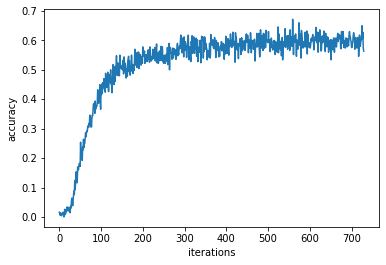

In [15]:
plt.plot(np.array(cp['accuracy']))
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

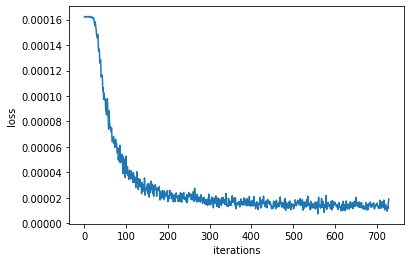

In [16]:
plt.plot(np.array(cp['loss']))
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

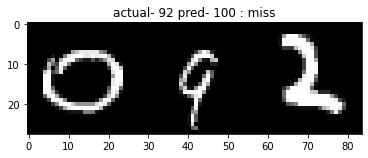

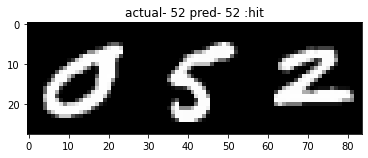

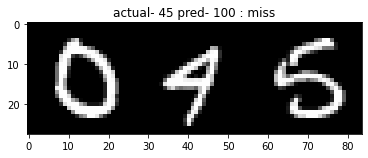

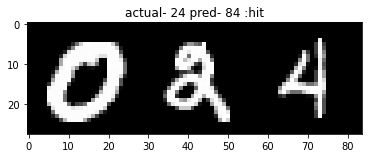

In [22]:
y_pred = model_lenet(X_test[:,np.newaxis, :, :].to(device))
y_pred =[torch.argmax(x.detach().cpu()) for x in y_pred]
y_pred = torch.stack(y_pred)

counter_miss = 2
counter_hit = 2
for index,(actual,pred) in enumerate(zip(y_test, y_pred)):
    if actual != pred and counter_miss > 0:
        plt.imshow(X_test[index].numpy(),cmap='gray')
        plt.title(f"actual- {actual} pred- {pred} : miss")
        plt.show()
        counter_miss-=1
    elif counter_hit > 0:
        plt.imshow(X_test[index].numpy(),cmap='gray')
        plt.title(f"actual- {actual} pred- {pred} :hit")
        plt.show()
        counter_hit-=1
    
    if counter_hit <= 0 and counter_miss <= 0:
        break

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


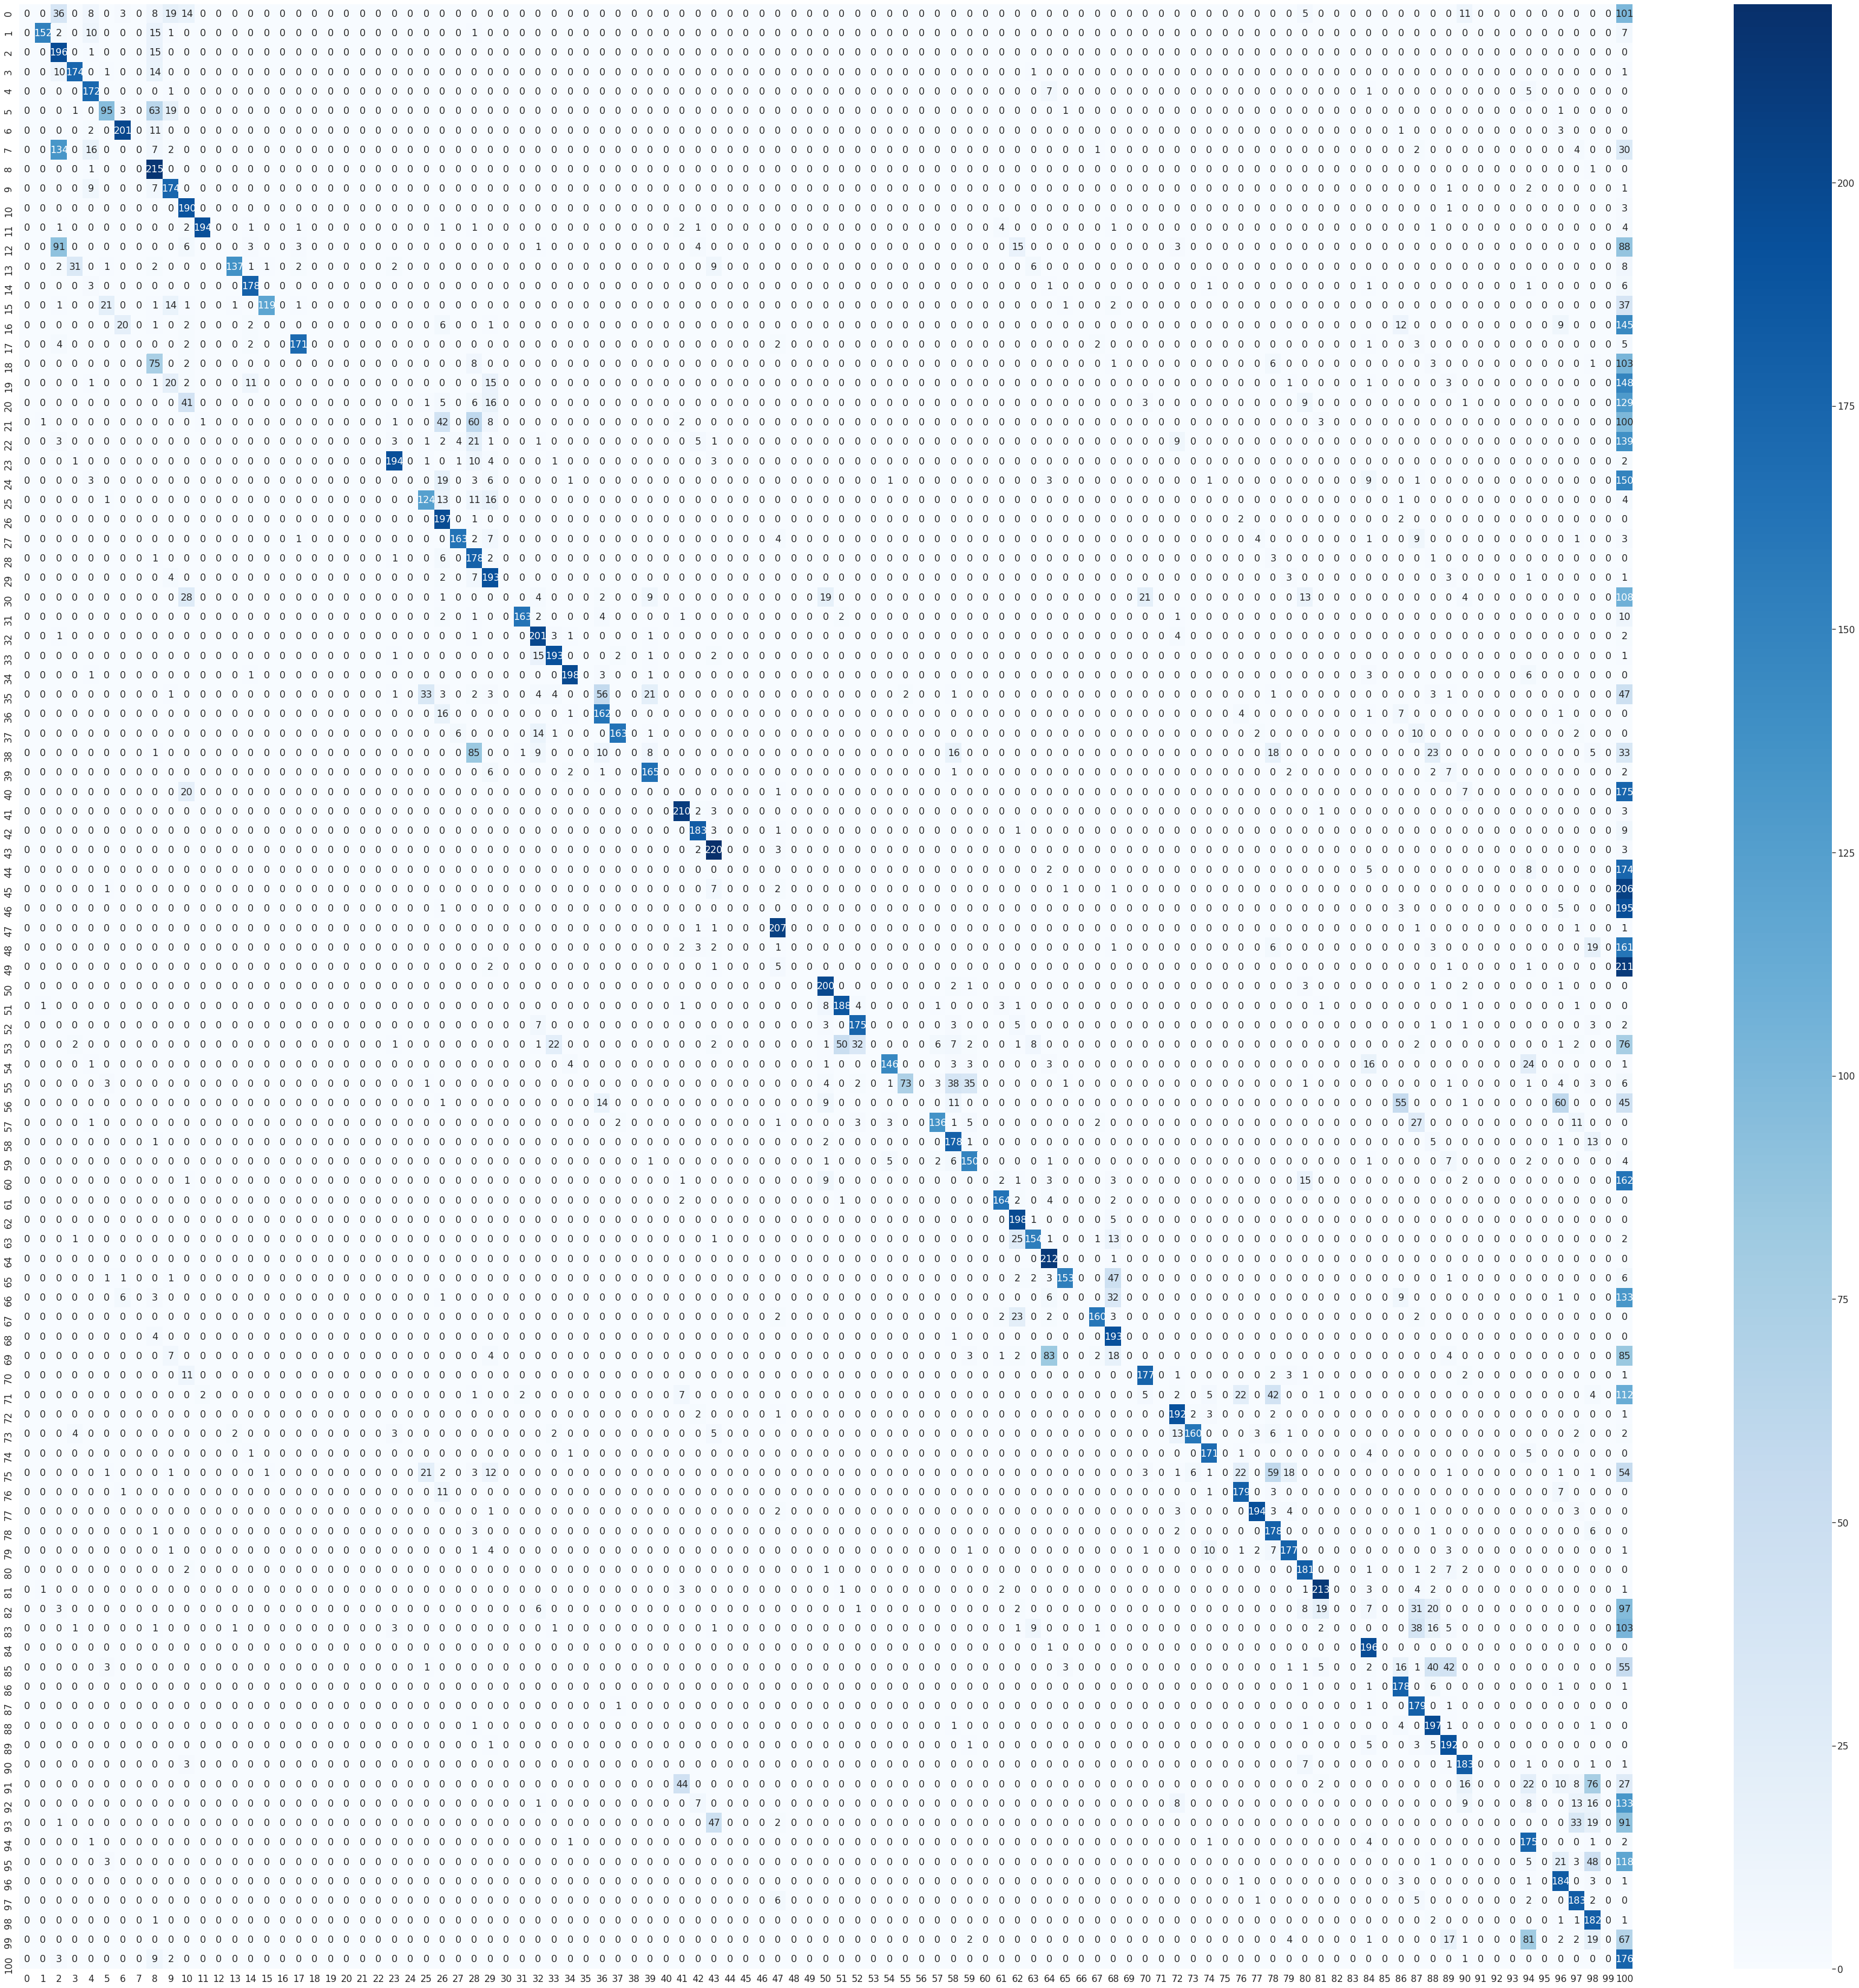

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


cm = confusion_matrix(y_test, y_pred).astype('uint8')

df_cm = pd.DataFrame(cm, index = [i for i in range(101)],
                  columns = [i for i in range(101)])
plt.figure(figsize = (60,60))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues',fmt='g');


In [29]:
print('Accuracy on Test: ',evaluate_accuracy(actual=y_test,prediction=y_pred,is_one_hot=False))

Accuracy on Test:  0.5846039603960396
